In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as smf

# Linear Regression 

### Import our data and merge the weather data with the bicycle dataset for both cities

In [2]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

In [3]:
marburg_weather["h"]= marburg_weather.index
marburg["h"]=marburg.index.floor(freq='h')
marburgWeather = pd.merge(marburg, marburg_weather, how='right', left_on='h', right_on='h')

duisburg_weather["h"]= duisburg_weather.index
duisburg["h"]=duisburg.index.floor(freq='h')
duisburgWeather = pd.merge(duisburg, duisburg_weather, how='right', left_on='h', right_on='h')

In [4]:
marburgWeather.head()

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,h,temperature,precipitation,cloud_coverage,wind_velocity
0,2019-07-04,13:29:00,11070.0,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3.0,13.0,41.0,2019-07-04 13:00:00,23.8,0.0,3,2.3
1,2019-07-04,13:48:00,11073.0,marburg,"(50.811, 8.7742)","(50.8167, 8.7812)",3.0,13.0,33.0,2019-07-04 13:00:00,23.8,0.0,3,2.3
2,2019-07-04,13:38:00,11076.0,marburg,"(50.7988, 8.7621)","(50.8229, 8.7747)",3.0,13.0,49.0,2019-07-04 13:00:00,23.8,0.0,3,2.3
3,2019-07-04,13:35:00,11080.0,marburg,"(50.8136, 8.7734)","(50.82, 8.7737)",3.0,13.0,15.0,2019-07-04 13:00:00,23.8,0.0,3,2.3
4,2019-07-04,13:54:00,11087.0,marburg,"(50.8229, 8.7747)","(50.811, 8.7742)",3.0,13.0,18.0,2019-07-04 13:00:00,23.8,0.0,3,2.3


We now have the weather data available for every single ride.

## Linear Regression for Marburg

### Define independent and dependent variables

Because we want to use Linear Regression to predict the bicycle demand, we have to define our independent and dependent variables.

We first start with a simple model that describes how temperature affects the bicycle demand. So we define the demand (the number of bicycles rented during each hour) as our dependent variable (y) and the temperature for each hour as our independent variable (x).

Let us start with the Marburg data:

In [5]:
ym = marburgWeather.resample('H', on="h").count()["day"].values
xm = marburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)

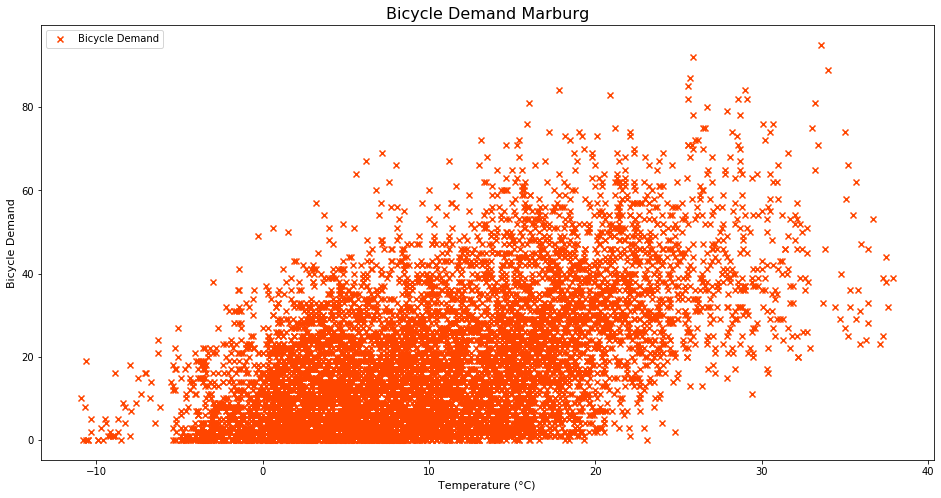

In [6]:
plt.figure(figsize = (16,8))
plt.scatter (xm, ym, marker = 'x', color = 'orangered', label = "Bicycle Demand")
plt.xlabel("Temperature (°C)", fontsize = 11)
plt.ylabel("Bicycle Demand", fontsize = 11)
plt.title("Bicycle Demand Marburg", fontsize = 16)
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

### Train / Test split

We split the data into a training and testing set, to better evaluate the model. We are using 70% of our data to train the model and 30% to test it.

In [7]:
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym, test_size=0.3, random_state=0)

### Initialize and fit a linear model with scikit-learn

In [8]:
linear_model_mar = LinearRegression()

We train our linear model with the training data.

In [9]:
linear_model_mar.fit(xm_train,ym_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Predict training data

Here we make predicitions with the predict() function on our testing set.

In [10]:
y_pred_m = linear_model_mar.predict(xm_test)

### Define y true

In [11]:
y_true_m = ym_test

### Plot the linear model

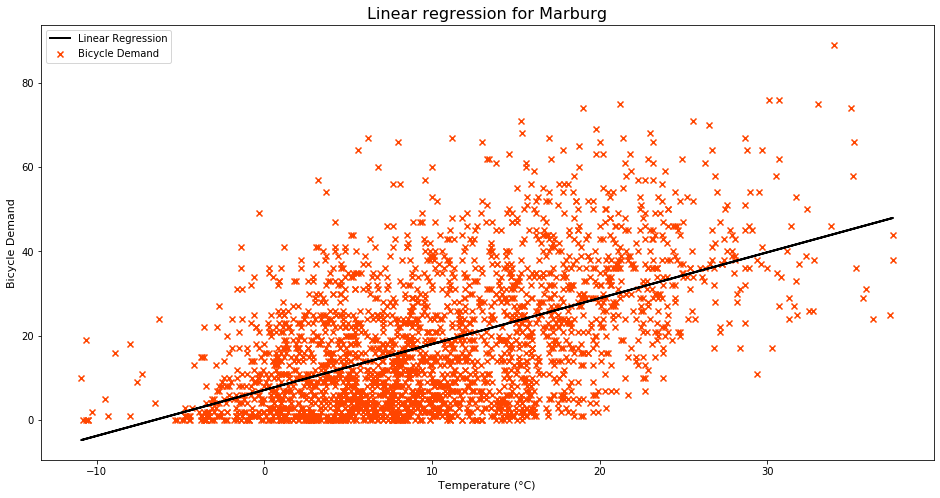

In [12]:
plt.figure(figsize = (16,8))

plt.scatter(xm_test, ym_test, marker="x", color = 'orangered', label = "Bicycle Demand")
plt.xlabel("Temperature (°C)", fontsize = 11)
plt.ylabel("Bicycle Demand", fontsize = 11)
plt.title("Linear regression for Marburg", fontsize = 16)

plt.plot(xm_test, y_pred_m, color = 'black', linewidth = 2, label = "Linear Regression")

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

### Present test metrics

Here we are evaluating our model with the Mean Absolute Error, the Mean Squared Error and the R^2 score.

In [13]:
print("Mean Absolute Error Marburg:",mean_absolute_error(y_true_m, y_pred_m),"Bicycles")
print("Mean Squared Error Marburg:",mean_squared_error(y_true_m, y_pred_m),"Bicycles")
print("Coefficient of determination Marburg:",r2_score(y_true_m, y_pred_m))

Mean Absolute Error Marburg: 10.556477708444188 Bicycles
Mean Squared Error Marburg: 177.54667444856273 Bicycles
Coefficient of determination Marburg: 0.2775329354520205


As you can see, the error metrics for our linear model are relatively bad, with a high MAE and MSE and a low R^2 Score (the R^2 Score lies between 0 and 1, with a higher score signifying a better model).

## Linear regression for Duisburg

Let us quickly repeat this process for the Duisburg dataset.

In [14]:
yd = duisburgWeather.resample('H', on="h").count()["day"].values

xd = duisburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)

xd_train, xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.3, random_state=0)

linear_model_dui = LinearRegression()

linear_model_dui.fit(xd_train,yd_train)

y_pred_d = linear_model_dui.predict(xd_test)

y_true_d = yd_test

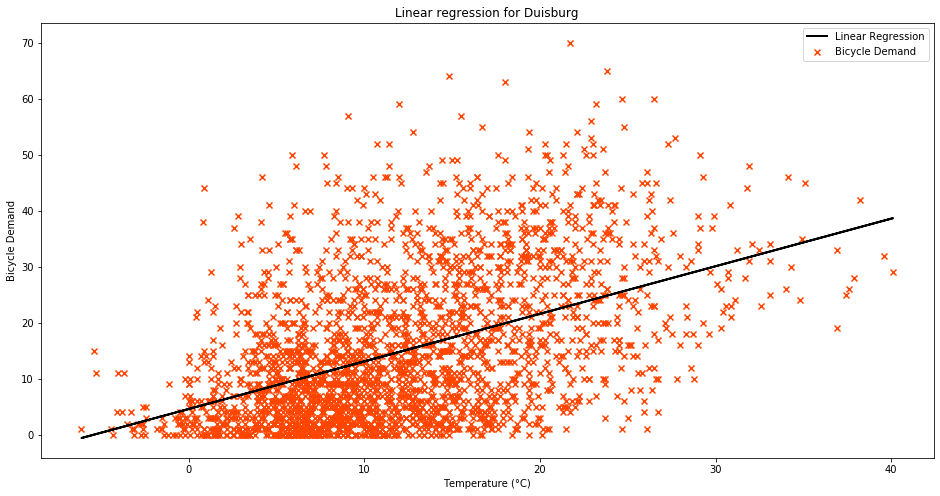

In [15]:
plt.figure(figsize = (16,8))

plt.scatter(xd_test, yd_test, marker="x", color = 'orangered', label = "Bicycle Demand")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Linear regression for Duisburg")

plt.plot(xd_test, y_pred_d, color = 'black', linewidth = 2, label = "Linear Regression")

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

In [16]:
print("Mean Absolute Error Duisburg:",mean_absolute_error(y_true_d, y_pred_d),"Bicycles")
print("Mean Squared Error Duisburg:",mean_squared_error(y_true_d, y_pred_d),"Bicycles")
print("Coefficient of determination Duisburg:",r2_score(y_true_d, y_pred_d))

Mean Absolute Error Duisburg: 9.0954293784692 Bicycles
Mean Squared Error Duisburg: 133.30951333972698 Bicycles
Coefficient of determination Duisburg: 0.2192743390838141


If we compare the test of Duisburg to those of Marburg we can observe smaller errors but a lower Coefficient of Determination.

# Multiple linear regression

Now let us try adding multiple features to our linear regression to see if it improves the performance of our model. We are starting with the Marburg data again.

We are adding another column "IsWeekday" to our data, that has the value 1 if the ride took place on a weekday and 0 if it happened on a weekend day.

In [17]:
marburgWeather["IsWeekday"] = marburgWeather["weekday"].map(lambda day : day<5)
marburgWeather.head(5)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,h,temperature,precipitation,cloud_coverage,wind_velocity,IsWeekday
0,2019-07-04,13:29:00,11070.0,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3.0,13.0,41.0,2019-07-04 13:00:00,23.8,0.0,3,2.3,True
1,2019-07-04,13:48:00,11073.0,marburg,"(50.811, 8.7742)","(50.8167, 8.7812)",3.0,13.0,33.0,2019-07-04 13:00:00,23.8,0.0,3,2.3,True
2,2019-07-04,13:38:00,11076.0,marburg,"(50.7988, 8.7621)","(50.8229, 8.7747)",3.0,13.0,49.0,2019-07-04 13:00:00,23.8,0.0,3,2.3,True
3,2019-07-04,13:35:00,11080.0,marburg,"(50.8136, 8.7734)","(50.82, 8.7737)",3.0,13.0,15.0,2019-07-04 13:00:00,23.8,0.0,3,2.3,True
4,2019-07-04,13:54:00,11087.0,marburg,"(50.8229, 8.7747)","(50.811, 8.7742)",3.0,13.0,18.0,2019-07-04 13:00:00,23.8,0.0,3,2.3,True


### Creating a new dataframe with all the features we need for our multiple linear regression 

For the multiple linear regression we are creating a new dataframe with all the features we want to use in our model.

These are the bicycle demand (what we want to predict with the other features), as well as the temperature, the precipitation, the hour of the day, the week of the year, the day of the week and whether the ride takes place on a weekday or on the weekend.

In [18]:
MulRegMar = pd.DataFrame()
MulRegMar["temperature"] = marburgWeather.resample('H', on="h").max()['temperature'].values
MulRegMar["IsWeekday"] = marburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegMar["Demand"] = marburgWeather.resample('H', on="h").count()["day"].values
MulRegMar["precipitation"] = marburgWeather.resample('H', on="h").max()['precipitation'].values
MulRegMar["hour"] = marburgWeather['hour']
MulRegMar["week"] = marburgWeather.h.map(lambda datetime : datetime.week)
MulRegMar["weekday"] = marburgWeather["weekday"]
MulRegMar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    8784 non-null   float64
 1   IsWeekday      8784 non-null   bool   
 2   Demand         8784 non-null   int64  
 3   precipitation  8784 non-null   float64
 4   hour           8784 non-null   float64
 5   week           8784 non-null   int64  
 6   weekday        8784 non-null   float64
dtypes: bool(1), float64(4), int64(2)
memory usage: 420.5 KB


### Define variables, split data set, fit model, predict value

Next, we once again define our dependent (ym2, "Demand") and independent (Xm2, "temperature", "precipitation", "IsWeekday", "hour", "week" and "weekday") variables.

Then we split the data into training and testing sets, fit the model with the training data and predict our values with the testing set.

In [19]:
Xm2 = MulRegMar[["temperature", "precipitation", "IsWeekday", "hour", "week", "weekday"]]
ym2 = MulRegMar["Demand"]
xm2_train, xm2_test, ym2_train, ym2_test = train_test_split(Xm2, ym2, test_size=0.3, random_state=0)
lin_mod_mul_m = LinearRegression()
lin_mod_mul_m.fit(xm2_train, ym2_train)
y_pred_m2 = lin_mod_mul_m.predict(xm2_test)
y_true_m2 = ym2_test

This is how the coefficients and the intercept of our linear Marburg model look like now:

In [20]:
print("The Coefficients for our multiple linear regression model for Marburg are:", "\n" "\n"
      "temperature   =   ", lin_mod_mul_m.coef_[0], "\n"
      "precipitation =  ", lin_mod_mul_m.coef_[1],"\n"
      "IsWeekday     =   ", lin_mod_mul_m.coef_[2],"\n"
      "hour          =   ", lin_mod_mul_m.coef_[3],"\n"
      "week          =   ", lin_mod_mul_m.coef_[4],"\n"
      "weekday       =   ", lin_mod_mul_m.coef_[5],"\n""\n"
      "The Intercept is:", lin_mod_mul_m.intercept_)

The Coefficients for our multiple linear regression model for Marburg are: 

temperature   =    1.0871742101474262 
precipitation =   -3.1678224591034017 
IsWeekday     =    7.620364509574234 
hour          =    0.1638038992254709 
week          =    0.1145158466025924 
weekday       =    0.3855710855970105 

The Intercept is: -5.3417331388514135


### Evaluate the test metrics

This is how the test metrics for our multiple linear regression look like for our Marburg model:

In [21]:
print("MAE Marburg:",mean_absolute_error(y_true_m2, y_pred_m2),"Bicycles")
print("MSE Marburg:",mean_squared_error(y_true_m2, y_pred_m2),"Bicycles")
print("R^2 Marburg:",r2_score(y_true_m2, y_pred_m2))

MAE Marburg: 10.01915196724127 Bicycles
MSE Marburg: 160.79742270283748 Bicycles
R^2 Marburg: 0.34568843754572476


As you can see, by adding multiple features to our Marburg model the values for the MAE and MSE have decreased slightly, while the Coefficient of Determination has increased.

## Multiple linear regression for Duisburg

We proceed analogously for the Duisburg data set.

In [22]:
duisburgWeather["IsWeekday"] = duisburgWeather["weekday"].map(lambda day : day<5)
MulRegDui = pd.DataFrame()
MulRegDui["temperature"] = duisburgWeather.resample('H', on="h").max()['temperature'].values
MulRegDui["IsWeekday"] = duisburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegDui["precipitation"] = duisburgWeather.resample('H', on="h").max()['precipitation'].values
MulRegDui["Demand"] = duisburgWeather.resample('H', on="h").count()["day"].values
MulRegDui["hour"] = duisburgWeather['hour']
MulRegDui["week"] = duisburgWeather.h.map(lambda datetime : datetime.week)
MulRegDui["weekday"] = duisburgWeather["weekday"]
Xd2 = MulRegDui[["temperature", "IsWeekday", "precipitation", "hour", "week", "weekday"]]
yd2 = MulRegDui["Demand"]
xd2_train, xd2_test, yd2_train, yd2_test = train_test_split(Xd2, yd2, test_size=0.3, random_state=0)
lin_mod_mul_d = LinearRegression()
lin_mod_mul_d.fit(xd2_train, yd2_train)
y_pred_d2 = lin_mod_mul_d.predict(xd2_test)
y_true_d2 = yd2_test

In [23]:
print("The Coefficients for our multiple linear regression model for Duisburg are: ", "\n" "\n"
      "temperature   =    ", lin_mod_mul_d.coef_[0], "\n"
      "precipitation =    ", lin_mod_mul_d.coef_[1],"\n"
      "IsWeekday     =   ", lin_mod_mul_d.coef_[2],"\n"
      "hour          =    ", lin_mod_mul_d.coef_[3],"\n"
      "week          =    ", lin_mod_mul_d.coef_[4],"\n" 
      "weekday       =    ", lin_mod_mul_d.coef_[5],"\n""\n"
      "The Intercept is:", lin_mod_mul_d.intercept_)

The Coefficients for our multiple linear regression model for Duisburg are:  

temperature   =     0.8846637499591592 
precipitation =     8.41730559787408 
IsWeekday     =    -2.0328963556914155 
hour          =     0.009916594925825917 
week          =     0.28289649289117946 
weekday       =     0.1618866485271142 

The Intercept is: -10.698246599413821


Here's what our test metrics look like for the multiple linear regression model for the Duisburg dataset:

In [24]:
print("MAE Duisburg:",mean_absolute_error(y_true_d2, y_pred_d2),"Bicycles")
print("MSE Duisburg:",mean_squared_error(y_true_d2, y_pred_d2),"Bicycles")
print("R^2 Duisburg:",r2_score(y_true_d2, y_pred_d2))

MAE Duisburg: 8.306410706755466 Bicycles
MSE Duisburg: 112.40151151333994 Bicycles
R^2 Duisburg: 0.34172181590224737


Similar to the Error metrics of the Marburg model, the MAE and MSE values have decreased, but for the Duisburg model the increase of the Coefficient of Determination was even more significant (from ~0.2193 to ~0.3417 compared to the Marburg model's increase from ~0.2775 to ~0.3457).

So while both linear regression models are performing quite poorly due to the obvious drawback of the model being linear, using multiple features instead of a single one helped in improving both of the model's accuracy.

## Visualizing multiple linear regression (with 2 independent variables) in a 3D plot

For multiple linear regression models it quickly becomes impossible to easily visualize the regression model together with all the features as you begin to add more and more independent variables.
But, when using just two independent variables (here: the temperature and precipitation), we can visualize the data and the regression model in a 3D plot.

To do so, we first create a new DataFrame with the features that we are going to use:

In [25]:
dftestmar = pd.DataFrame()
dftestmar["Demand"] = MulRegMar["Demand"]
dftestmar["temperature"] = MulRegMar["temperature"]
dftestmar["precipitation"] = MulRegMar["precipitation"]
dftestmar.head()

,Demand,temperature,precipitation
0,7,-7.9,0.0
1,8,-8.3,0.0
2,5,-8.7,0.0
3,1,-8.9,0.0
4,2,-8.7,0.0


We then create our model, this time using the statsmodels library instead of scikit-learn.

In [26]:
model = smf.ols(formula = 'Demand ~ temperature + precipitation', data =dftestmar)
results_formula = model.fit()
results_formula.params

Intercept        7.653484
temperature      1.071697
precipitation   -3.604767
dtype: float64

In [27]:
x_surf, y_surf = np.meshgrid(np.linspace(dftestmar.temperature.min(), dftestmar.temperature.max(), 100), np.linspace(dftestmar.precipitation.min(), dftestmar.precipitation.max(), 100))
onlyX = pd.DataFrame({'temperature': x_surf.ravel(), 'precipitation': y_surf.ravel()})
fittedY = results_formula.predict(exog = onlyX)
fittedY = np.array(fittedY)

Now we can plot the data and the linear model in the three-dimensional space:

<IPython.core.display.Javascript object>


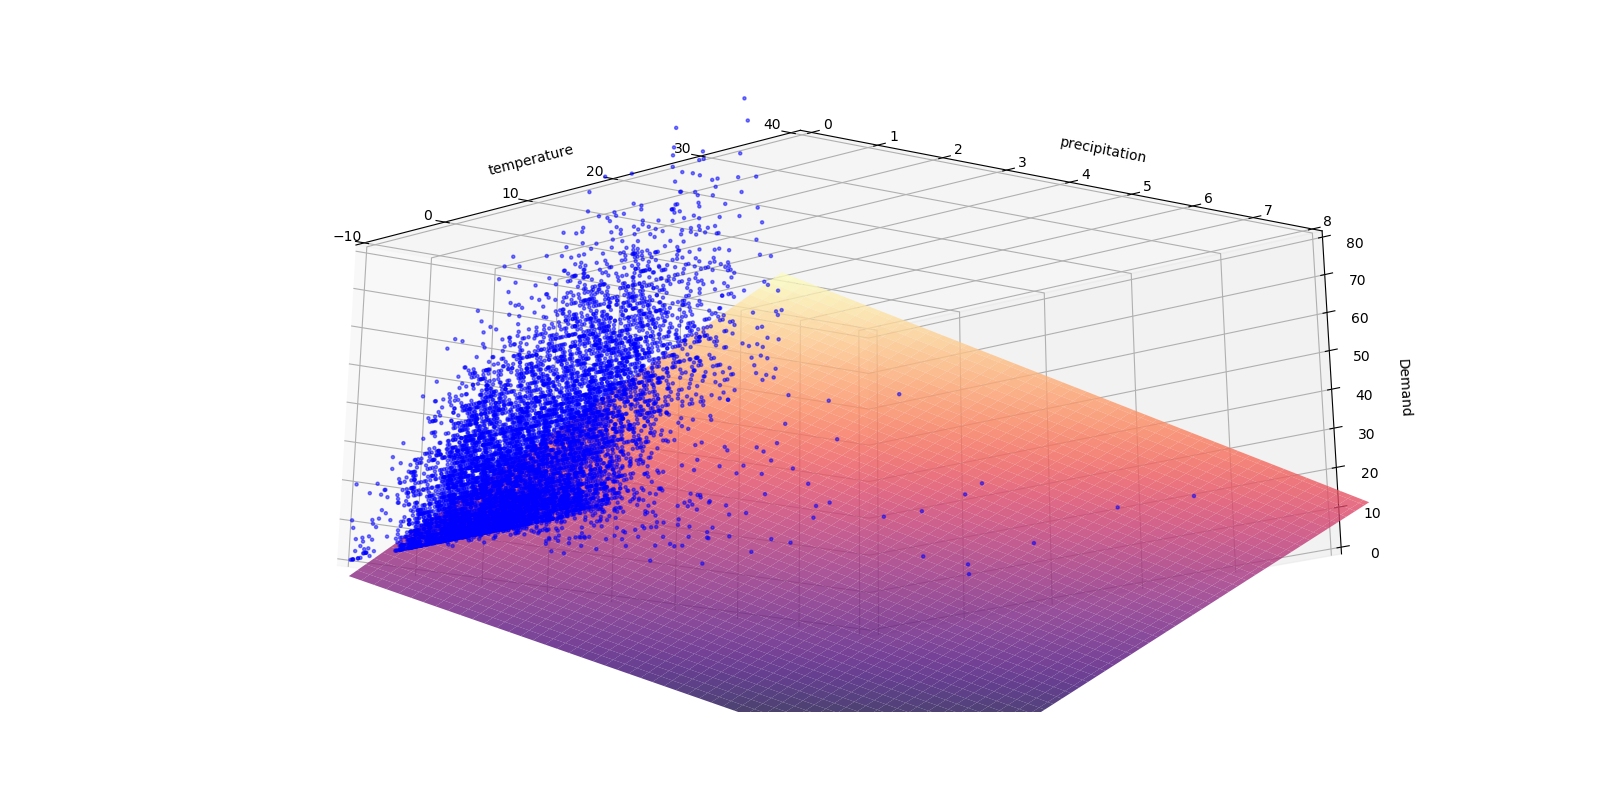

In [28]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d 

fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(dftestmar["temperature"], dftestmar["precipitation"], dftestmar["Demand"], c = 'blue', marker = '.', alpha = 0.5)
ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), cmap='magma', linewidth = 0.5, alpha = 0.8)


ax.set_xlim(-10, 40)
ax.set_ylim(0, 8)
ax.set_zlim(0, 80)

ax.set_xlabel('temperature')
ax.set_ylabel('precipitation')
ax.set_zlabel('Demand')


plt.show()

Note: This graph does not belong to our multiple linear regression model that we build before. It just shows a way to visualize linear regression with 2 independent variables.